# PROBLEMA DO CAMINHO MÍNIMO


O _Problema do Caminho Mínimo_ é o seguinte: dados um grafo ponderado (com pesos, ou distâncias) e dois de seus vértices, encontrar o caminho nesse grafo que ligue os dois vértices dados e tenha o menor peso (distância) total possível.  Uma descrição mais detalhada, incluindo definições e exemplos dos conceitos necessários para entender esse problema, está contida no <a href="">... link ...</a>.

Nesse _notebook_, serão apresentadas implementações comentadas de alguns algoritmos usados para resolver esse problema: _Busca Exaustiva_, o _Algoritmo de Dijkstra_ e uma _heurística gulosa_.  Em seguida, essas implementações serão comparadas.


## Bibliotecas

Para começar, vamos carregar as quatro bibliotecas do ``Python`` que serão usadas nesse _notebook_.  A primeira delas, ``heapq``, será usada no Algoritmo de Dijkstra para criar listas de prioridades. A segunda, ``time``, será usada para calcular e comparar os tempos de execução dos algoritmos implementados, a terceira é a ``matplotlib.pyplot`` que será utilizada para plotar os graficos referentes às comparações entre os algoritmos, e a quarta é a ``math`` utilizada para verificar a proximidade dos numeros avaliados com segurança (garantir que dois numeros como 3 e 3.0 sejam "iguais")


In [12]:
#Bibliotecas para criação e medição dos algoritmos
import heapq
import math
import time

#Biblioteca para plotar os gráficos
import matplotlib.pyplot as plt

#Biliotecas para gerar grafos aleatórios
from os import uname
import networkx as nx
import random

#Bibliotecas utilizadas para análise dos dados
import numpy as np
import pandas as pd


## Implementações dos algoritmos


In [5]:
# Essa é uma função auxiliar, que será usada para verificar se existe algum
# caminho entre dois vértices de um grafo.  Concretamente, ela constrói o
# conjunto de todos os vértices que estão conectados ao vértice-base, ou seja,
# a componente conexa do vértice-base no grafo:
# http://en.wikipedia.org/wiki/Connectivity_(graph_theory)#Components_and_cuts

def componente_conexa (grafo, vertice_base):
    if vertice_base in grafo:
        componente_conexa = set()
        vizinhos = {vertice_base}

        while componente_conexa != vizinhos:
            componente_conexa = vizinhos.copy()
            for vertice in componente_conexa:
                vizinhos.update(grafo[vertice])

        return componente_conexa

    else:
        print(f"O vértice {vertice_base} não pertence ao grafo.")
        return None


### **Busca Exaustiva**

In [6]:
#########################
###  BUSCA EXAUSTIVA  ###
#########################


def busca_exaustiva (grafo, vertice_inicial, vertice_final):
    """
    Busca exaustiva: dado um grafo ponderado e dois de seus vértices, realiza
    uma busca exaustiva para encontrar o caminho mínimo entre esses vértices.

    Parâmetros:
    - grafo (dict): Um dicionário representando o grafo, onde as chaves são os
      vértices e os valores são listas de vértices vizinhos e suas distâncias.
    - vertice_inicial: O vértice de partida para a busca.
    - vertice_final: O vértice de destino para a busca.

    Retorna: uma tupla contendo:
    - caminho_minimo (list): uma lista representando o caminho mínimo entre o
       vértice inicial e o vértice final.
    - menor_distância (float): um número representando o comprimento total do
      caminho mínimo.
    - tempo_execucao (float): um número representando o tempo total de
      execução do algoritmo.

    Complexidade: O(d^|V|), d é o grau do grafo e |V| é o número de vértices
      do grafo dado.
    """

    # Validações básicas
    if not componente_conexa(grafo, vertice_inicial):
        return None, None, None
    elif vertice_final not in grafo:
        print(f"O vértice final {vertice_final} não pertence ao grafo.")
        return None, None, None
    elif vertice_final not in componente_conexa(grafo, vertice_inicial):
        return None, None, None
    #else: como os dois vértices pertencem ao grafo dado e como existe um
    #  caminho entre o vértice inicial e o vértice final, continuamos...

    # Horário do início do algoritmo
    horario_inicio = time.time()

    # Lista que vai guardar os caminhos já construídos e seus comprimentos.
    lista = []

    # Lista que vai guardar os caminhos expandidos. Inicializamos essa lista
    # só com o vértice inicial, que é como se fosse uma expansão da lista
    # vazia.
    nova_lista = [{'caminho': [vertice_inicial], 'comprimento': 0}]

    # Enquanto os caminhos ainda puderem ser expandidos:
    while nova_lista != lista:
        # Atualizamos a lista de caminhos já construídos
        lista = nova_lista

        # Construímos uma nova lista de caminhos expandidos
        nova_lista = []

        for elemento in lista:
            novos_elementos = expandir_caminho(grafo, vertice_final, elemento['caminho'], elemento['comprimento'])
            nova_lista += [{'caminho': caminho, 'comprimento': comprimento}  for caminho, comprimento in novos_elementos]

    # Quando os caminhos não puderem mais ser expandidos, calcular o caminho
    # mínimo e seu comprimento
    menor_distancia = min([item['comprimento']  for item in lista])
    caminho_minimo = [item['caminho']  for item in lista if item['comprimento'] == menor_distancia][0]

    # Calcular o tempo tota de execução do algoritmo
    tempo_execucao = time.time() - horario_inicio

    return caminho_minimo, menor_distancia, tempo_execucao


def expandir_caminho(grafo, vertice_final, caminho, comprimento):
    # Tomar o último vértice do caminho
    ultimo_vertice = caminho[-1]

    # Se o último vértice já for o vértice final, não precisa expandir
    if ultimo_vertice == vertice_final:
        return [(caminho, comprimento)]

    # Se não, pegamos todos os vizinhos do último vértice que ainda não estão
    # no caminho e expandimos o caminho inicial com cada um deles
    else:
        vizinhos_nao_visitados = {(vertice, distancia)  for vertice, distancia in grafo[ultimo_vertice].items() if vertice not in caminho}
        caminhos_expandidos = [([*caminho, vertice], comprimento + distancia)  for vertice, distancia in vizinhos_nao_visitados]
        return caminhos_expandidos


### **Heurística Gulosa**

In [7]:
###########################
###  HEURISTICA GULOSA  ###
###########################


def heuristica_gulosa (grafo, vertice_inicial, vertice_final):
    """
    Heurística Gulosa: dados um grafo ponderado e dois vértices, essa função
    encontra um caminho do vértice inicial até o vértice final que segue as
    arestas de peso mínimo. (Esse caminho pode não ser o caminho mínimo!)

    Parâmetros:
    - grafo (dict): Dicionário de adjacências que representa o grafo
      ponderado. As chaves são os vértices do grafo e os valores são
      dicionários, cujas chaves são os vizinhos e os valores são os pesos das
      arestas que ligam os vértices.
    - vertice_inicial: Vértice inicial do caminho. Se esse vértice não
      pertencer ao grafo, a função retorna None (e uma mensagem de erro).
    - vertice_final: Vértice final do caminho. Se esse vértice não pertencer
      ao grafo, a função retorna None (e uma mensagem de erro).

    Saídas:
    - caminho (list): Uma lista contendo os vértices do caminho encontrado.
    - peso_total (float): Soma dos pesos das arestas do caminho encontrado.
    - tempo_execucao (float): Tempo total de execução da heurística (em segs).

    Complexidade: O(|V|^2 + |E|), onde |V| é o número de vértices e |E| é o
      número de arestas do grafo dado.
    """

    # Começo do cálculo do tempo de execução do algoritmo
    horario_inicio = time.time()

    # Validações básicas
    if not componente_conexa(grafo, vertice_inicial):
        return None, None, None
    elif vertice_final not in grafo:
        print(f"O vértice final {vertice_final} não pertence ao grafo.")
        return None, None, None
    elif vertice_final not in componente_conexa(grafo, vertice_inicial):
        return None, None, None
    #else: como os dois vértices pertencem ao grafo dado e como existe um
    #  caminho entre o vértice inicial e o vértice final, continuamos...

    # Preparação para o loop principal:
    # - conjunto de vértices não visitados
    nao_visitados = set(grafo)
    # - lista que vai guardar o caminho do vértice inicial ao final
    caminho = []
    # - variável que vai guardar o peso total do caminho acima
    peso_total = 0.0
    # - vértice que estará sendo analisado em cada iteração do loop
    vertice_atual = vertice_inicial

    # Loop que só para quando chegamos ao vértice final, ou ...
    while vertice_atual != vertice_final:
        # Incluir o vértice atual ao caminho
        caminho.append(vertice_atual)
        # Remover o vértice atual do conjunto de vértices não visitados
        nao_visitados.discard(vertice_atual)
        # Dicionário contendo os vizinhos do vértice atual que ainda não foram
        # visitados e os pesos das respectivas arestas
        vizinhos_nao_visitados = {vizinho: peso  for vizinho, peso in grafo[vertice_atual].items() if vizinho in nao_visitados}

        if vizinhos_nao_visitados:
            # O vértice atual para a próxima iteração será o vizinho mais próximo
            vertice_atual = min(vizinhos_nao_visitados, key=vizinhos_nao_visitados.get)
            # Adicionar o tamanho da aresta ligando os vértices atuais ao peso total
            peso_total += vizinhos_nao_visitados[vertice_atual]
        else:
            #FIXME  Ao invés de 'break', nós poderíamos dar um passo atrás
            #       (voltar um vértice) e continuar tentando...
            break

    if vertice_atual == vertice_final:
        # Incluir o último vértice no caminho
        caminho.append(vertice_atual)

        # Calcular o tempo total de execução do algoritmo
        tempo_execucao = time.time() - horario_inicio

        return caminho, peso_total, tempo_execucao

    else: # Não foi possível alcançar o vértice final com a heurística gulosa
        #TODO  Isso realmente pode acontecer?
        return None, None, None


### **Algoritmo de Dijkstra**

In [8]:
###############################
###  ALGORITMO DE DIJKSTRA  ###
###############################


def dijkstra (grafo, vertice_inicial):
    """
    Algoritmo de Dijkstra: dado um grafo ponderado e um vértice inicial,
    encontra os caminhos mínimos desse vértice inicial até os outros vértices
    do grafo.

    Parâmetros:
    - grafo (dict): Dicionário de adjacências que representa o grafo
      ponderado. As chaves são os vértices do grafo e os valores são
      dicionários, cujas chaves são os vizinhos e os valore são os pesos das
      arestas que ligam os vértices.

    - vertice_inicial (dict_keys): O vértice inicial dos caminhos mínimo que
      queremos calcular. Se o vértice dado não pertencer ao grafo dado, a
      função retorna None (e imprime uma mensagem de erro).

    Saídas:
    - distancias (dict): Um dicionário contendo os caminhos mínimos do vértice
      inicial aos outros vértices do grafo. As chaves desse dicionário são os
      vértices do grafo e os valores são listas formadas pela distância total
      e pelo último vértice do caminho mínimo.

    - tempo_execucao (float): Tempo total de execução do algoritmo (em segs).

    Complexidade: O(|E| + |V|*log|V|), onde |E| é o número de arestas e |V| é
      o número de vértices do grafo dado.
    """

    # Começo do cálculo do tempo de execução do algoritmo (O(|E| + |V|log|V|))
    horario_inicio = time.time()

    # Validação básica
    if vertice_inicial not in grafo:
        print(f"O vértice inicial {vertice_inicial} não pertence ao grafo.")
        return None, None
    #else: como o vértice inicial pertence ao grafo dado, continuamos...

    # Dicionário criado para alocar: a menor distância entre o vértice inicial
    # e os outros vértices do grafo, e o caminho mínimo. Esse dicionário é
    # inicializado com infinito para todos os vértices (porque ainda não
    # calculamos nada).
    distancias = {vertice: [float('infinity'), vertice_inicial]  for vertice in grafo}

    # Depois definimos a distância do vértice inicial a ele mesmo como sendo 0
    distancias[vertice_inicial][0] = 0

    # Definição do conjunto de vértices que ainda precisam ser analisados
    nao_visitados = {vertice  for vertice in grafo}

    # Definição de uma lista que, junto com o conjunto de vértices não-
    # -visitados, vai ser usada para determinar o próximo vértice a ser
    # analisado. Essa lista é inicializada com (0, vertice_inicial) por dois
    # motivos: para ser não-vazia, e para que a primeira iteração do loop
    # inclua nela todos os vizinhos do vértice inicial.
    fila_prioridade = [(0, vertice_inicial)]

    # Observe que a fila de prioridade vai ser vazia quando não existir mais
    # nenhum vizinho a ser analisado
    while fila_prioridade:
        # Reordenar a fila de prioridade por ordem de distância e extrair o
        # primeiro item dessa lista. Esse vértice será o vizinho mais próximo
        # do vértice anterior que ainda não foi analisado.
        heapq.heapify(fila_prioridade)
        distancia_atual, vertice_atual = heapq.heappop(fila_prioridade)

        # Se a distância atual é maior do que a distância armazenada, ignore
        if distancia_atual > distancias[vertice_atual][0]:
            continue
        else:
            for vizinho, peso in grafo[vertice_atual].items():
                # Para cada vizinho do vértice atual, verificar se a distância
                # do caminho que passa pelo vértice atual e vai para esse
                # vizinho é menor que a distância que nós tínhamos calculado
                # antes. Se for, atualiza o valor da distância mínima.
                if distancia_atual + peso < distancias[vizinho][0]:
                    distancias[vizinho] = [distancia_atual + peso, vertice_atual]
                #else: mantemos a distância que nós já tínhamos, que é menor

            # Como o vértice atual já foi analisado, exclua ele do conjunto de
            # vértices não-visitados
            nao_visitados.discard(vertice_atual)

            # Atualize a fila de prioridade com os vizinhos não-visitados do
            # vértice atual
            fila_prioridade = [(distancias[vizinho][0], vizinho)  for vizinho in list(grafo[vertice_atual]) if vizinho in nao_visitados]

    # Cálculo do tempo total de execução
    tempo_execucao = time.time() - horario_inicio

    return reconstruir_caminhos(distancias, vertice_inicial), tempo_execucao


def reconstruir_caminhos (dicionario_distancias, vertice_inicial):
    caminhos_minimos = {}

    for a in dicionario_distancias:
        ultimo = a;
        caminho = [a]

        while ultimo != vertice_inicial:
            caminho.insert(0, dicionario_distancias[ultimo][1])
            ultimo = dicionario_distancias[ultimo][1]

        caminhos_minimos[a] = [dicionario_distancias[a][0], caminho]

    return caminhos_minimos


### **Algoritmo de Bellman-Ford**

In [9]:
###################################
###  ALGORITMO DE BELLMAN-FORD  ###
###################################

def bellman_ford(grafo,vertice_inicial):
  """
  Algoritmo de Bellman-ford: dado um grafo ponderado e um vértice inicial,
  encontra os caminhos mínimos desse vértice inicial até os outros vértices
  do grafo. (Quebra limitações de dijkstra, o grafo pode ter pesos negativos)

  Parâmetros:
  - grafo (dict): Dicionário de adjacências que representa o grafo
    ponderado. As chaves são os vértices do grafo e os valores são
    dicionários, cujas chaves são os vizinhos e os valore são os pesos das
    arestas que ligam os vértices.

  - vertice_inicial (dict_keys): O vértice inicial dos caminhos mínimo que
    queremos calcular. Se o vértice dado não pertencer ao grafo dado, a
    função retorna None (e imprime uma mensagem de erro).

  Saídas:
  - distancias (dict): Um dicionário contendo os caminhos mínimos do vértice
    inicial aos outros vértices do grafo. As chaves desse dicionário são os
    vértices do grafo e os valores são listas formadas pela distância total
    e pelo último vértice do caminho mínimo.

  - tempo_execucao (float): Tempo total de execução do algoritmo (em segs).

  Complexidade: O(|V|*|E|), onde |E| é o número de arestas e |V| é
    o número de vértices do grafo dado.
  """
  horario_inicio = time.time()
  if vertice_inicial not in grafo:
    print(f"O vértice inicial {vertice_inicial} não pertence ao grafo.")
    return None, None
  pass


## Considerações finais


* Heurística gulosa é mais rápida que Dijkstra,
    - Um exemplo concreto
    - Uma comparação de médias

* Dijkstra é mais rápido que a Busca exaustiva,
    - Um exemplo concreto
    - Uma cota de quando a Busca Exaustiva já não dá conta

* Heurística gulosa erra com frequência.
    - Um exemplo concreto
    - Uma média genérica


### Grafos Utilizados


In [14]:
# Exemplos de grafos

#<|>-
grafo1 = {
   'A': {'B': 1, 'C': 4, 'E': 20},
   'B': {'A': 1, 'C': 2, 'D': 5},
   'C': {'A': 4, 'B': 2, 'D': 1},
   'D': {'B': 5, 'C': 1},
   'E': {'A': 20}
}

#K4 ou <+>
grafo2 = {
    'A': {'B': 1.4, 'C': 1, 'D': 1.4},
    'B': {'A': 1.4, 'C': 1, 'D': 2},
    'C': {'A': 1, 'B': 1, 'D': 1},
    'D': {'A': 1.4, 'B': 2, 'C': 1}
}

#<>
grafo3 = {
   'A': {'B': 1, 'C': 4},
   'B': {'A': 1, 'D': 5},
   'C': {'A': 4, 'D': 1},
   'D': {'B': 5, 'C': 1}
}


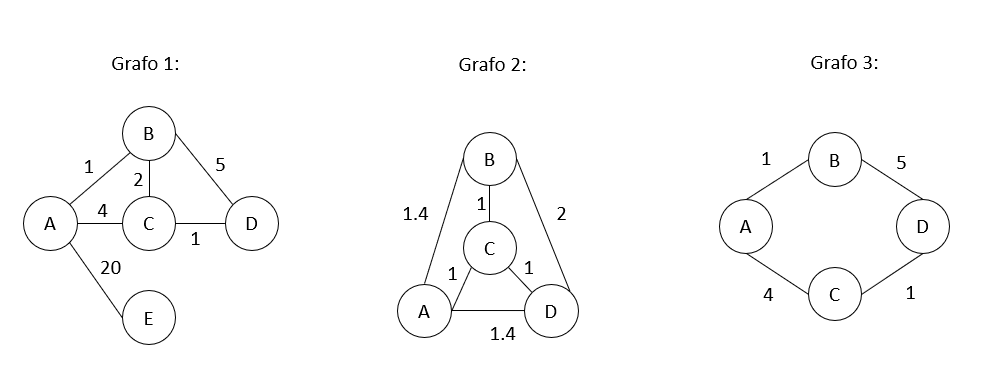

###Tempo **Dijkstra x Gulosa**

Para um primeiro exemplo vamos utilizar o grafo 2 pois queremos verificar o tempo de execução de um algoritmo para o outro.

In [15]:
distancia_dij, tempo_dij = dijkstra(grafo2, 'A')
distancia_g, peso, tempo_g = heuristica_gulosa(grafo2, 'A','D')

print(f'Tempo do algoritmo de Dijkstra: {tempo_dij}')
print(f'Tempo da heurística gulosa: {tempo_g}')

print(f'\nA heurística gulosa é {tempo_dij - tempo_g} mais rapida que dijkstra')

Tempo do algoritmo de Dijkstra: 7.748603820800781e-05
Tempo da heurística gulosa: 3.2901763916015625e-05

A heurística gulosa é 4.458427429199219e-05 mais rapida que dijkstra


Para uma análise mais aprofundada, criamos um algoritmo para gerar muitos grafos e tirar uma média de cada tempo de execução e no final comparar entre a heurística gulosa e Dijkstra

###Tempo **Dijkstra x Gulosa** Comparação de médias

In [16]:
def gerar_grafo(i):
    p = random.random() # porcentagem de arestas aleatória

    grafo_abstr = nx.gnp_random_graph(i, p)
    grafo = nx.to_dict_of_dicts(grafo_abstr)

    for vertice in grafo:
        for vizinho in grafo[vertice]:
            grafo[vertice][vizinho] = random.randint(1, i) # pesos aleatórios

    return grafo
#Criação de váriaveis para armazenar os dados estatísticos do tempo
tempo_por_loop_g = []
tempo_por_loop_d = []

porcentagens_de_acertos = []
j = 0
p = 0
u = []
total_acertos_tabela = []
total_porcentagens_tabela = []
f = 0 #indice de numero de vertices
n_grafos = [3,4,5,7,10,25,50] #numero de grafos gerados
for f in n_grafos:
  for n in n_grafos:
    for i in range(n):
      u.append(gerar_grafo(n))
      #Fazer um vetor que guarde todo o tempo de execução de dijkstra
      peso_ultimo_vertice_djk = []
      lista_tempo_dijkstra = []

      #aplicando dijkstra para os grafos
      for i in range(len(u)):
        d_dij, t_dij = dijkstra(u[i],list(u[i])[0])
        if d_dij != None:
          tamanho = len(d_dij)
          peso_ultimo_vertice_djk.append(d_dij[tamanho-1][0])
          if peso_ultimo_vertice_djk[len(peso_ultimo_vertice_djk) - 1] == float('inf'):
            lista_tempo_dijkstra.append(None)
          else:
            lista_tempo_dijkstra.append(t_dij)

      #retirando a redundância e erro dos dados
      itens_para_remover = [None]
      lista_tempo_dijkstra = [item for item in lista_tempo_dijkstra if item not in itens_para_remover]

      #aplicando a heuristica gulosa para os grafos
      lista_tempo_gulosa = []
      peso_gulosa = []
      lista_tempo_gulosa = []
      peso_gulosa = []
      for i in range(len(u)):
        d_gul, p_gul, tempo_gul = heuristica_gulosa(u[i],list(u[i])[0], len(u[i]) - 1)
        lista_tempo_gulosa.append(tempo_gul)

      #retirando a redundância e erro dos dados
      itens_para_remover = [None]
      lista_tempo_gulosa = [item for item in lista_tempo_gulosa if item not in itens_para_remover]

      #Tempo médio em um vetor
      if lista_tempo_gulosa != [] and lista_tempo_dijkstra != []:
        tempo_gul_medio = sum(lista_tempo_gulosa)/len(lista_tempo_gulosa)
        tempo_por_loop_g.append(tempo_gul_medio)
        tempo_dij_medio = sum(lista_tempo_dijkstra)/len(lista_tempo_dijkstra)
        tempo_por_loop_d.append(tempo_dij_medio)
        j += 1




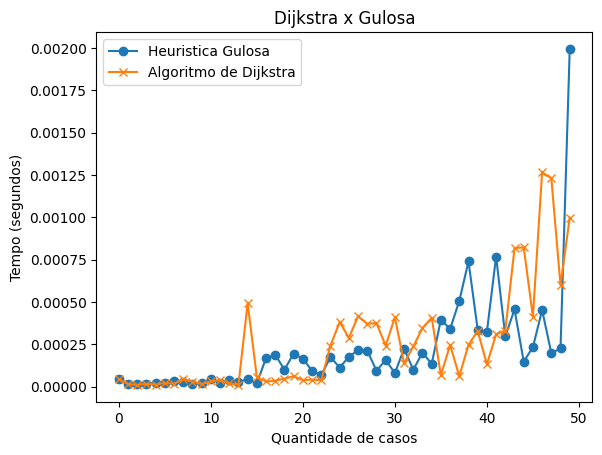

 
Tempo médio da Heurística gulosa: 0.00015684365454128943 x Tempo médio Algoritmo de Dijkstra: 0.00028060824895563145


In [17]:
# Plotando o gráfico
lista_reduzida_g = lista_tempo_gulosa[:50]
lista_reduzida_d = lista_tempo_dijkstra[:50]

plt.plot(lista_reduzida_g, label='Heuristica Gulosa', marker='o')  # Linha para resultados da heuristica gulosa
plt.plot(lista_reduzida_d, label='Algoritmo de Dijkstra', marker='x')  # Linha para resultados do algoritmo de dijktra

# Adicionando título e rótulos
plt.title('Dijkstra x Gulosa')
plt.xlabel('Quantidade de casos')
plt.ylabel('Tempo (segundos)')
plt.legend()

# Exibir o gráfico
plt.show()
print(" ")

tempo_medio_dijkstra = sum(tempo_por_loop_d)/len(tempo_por_loop_d)
tempo_medio_gulosa = sum(tempo_por_loop_g)/len(tempo_por_loop_g)
print(f'Tempo médio da Heurística gulosa: {tempo_medio_gulosa} x Tempo médio Algoritmo de Dijkstra: {tempo_medio_dijkstra}')

###Tempo **Dijkstra x Exaustiva**

Aqui faremos uma pequena analise da diferença do tempo de execução de dijkstra com a busca exaustiva utilizando os grafos já apresentados

In [18]:
caminho_ex, peso_ex, tempo_ex = busca_exaustiva(grafo1,'A','D')
distancia_dij, tempo_dij = dijkstra(grafo2, 'A')

print(f'Tempo do algoritmo de Dijkstra: {tempo_dij}')
print(f'Tempo da busca_exaustiva: {tempo_ex}')

print(f'\nO algoritmo de dijkstra é {tempo_ex - tempo_dij} mais rapido do que a busca_exaustiva')

Tempo do algoritmo de Dijkstra: 4.38690185546875e-05
Tempo da busca_exaustiva: 6.246566772460938e-05

O algoritmo de dijkstra é 1.8596649169921875e-05 mais rapido do que a busca_exaustiva


### Até onde vai a **busca exaustiva**

Faremos varios casos para testar qual o tamanho de um grafo que a busca exaustiva aguenta

In [19]:
def gerar_grafo(i):
    p = random.random() # porcentagem de arestas aleatória

    grafo_abstr = nx.gnp_random_graph(i, p)
    grafo = nx.to_dict_of_dicts(grafo_abstr)

    for vertice in grafo:
        for vizinho in grafo[vertice]:
            grafo[vertice][vizinho] = random.randint(1, i) # pesos aleatórios

    return grafo

teste = [5,6,7,8,9,10,11,12,13,14,15]
for i in teste:
  g = gerar_grafo(i)
  print(i) #Demora mais de 2 min para rodar com teste = 13, ou seja, um grafo com 13 vértices
  caminho_ex, peso_ex, tempo_ex = busca_exaustiva(g,0,i - 1)
  print(caminho_ex,peso_ex,tempo_ex)

5
[0, 4] 5 4.6253204345703125e-05
6
[0, 5] 1 2.5033950805664062e-05
7
[0, 3, 6] 7 0.00048828125
8
[0, 7] 3 0.001986980438232422
9
None None None
10
None None None
11
[0, 6, 10] 9 0.006336688995361328
12
None None None
13
[0, 7, 12] 6 10.782659769058228
14


KeyboardInterrupt: 

### **Erro Heurística Gulosa** (Utilizando o grafo 2)


In [20]:
#Utilizando o grafo 2
q, w, e = busca_exaustiva(grafo1,'A','D')
v, b = dijkstra(grafo2, 'A')

# Peso de A até D em dijkstra => v['D'][0]

p_dj = v['D'][0]
print(f'Peso heurística gulosa {w} e Peso Dijkstra {p_dj}, portanto heuristica gulosa erra')
print(f'mas qual sua taxa de erro?')

Peso heurística gulosa 4 e Peso Dijkstra 1.4, portanto heuristica gulosa erra
mas qual sua taxa de erro?


### **Média** para mensurar o **erro da heuristica gulosa**

In [26]:
def gerar_grafo(i):
    p = random.random() # porcentagem de arestas aleatória

    grafo_abstr = nx.gnp_random_graph(i, p)
    grafo = nx.to_dict_of_dicts(grafo_abstr)

    for vertice in grafo:
        for vizinho in grafo[vertice]:
            grafo[vertice][vizinho] = random.randint(1, i) # pesos aleatórios

    return grafo

#Criação de váriaveis para armazenar os dados estatísticos do tempo
porcentagens_de_acertos = []
j = 0
p = 0
u = []
total_acertos_tabela = []
total_porcentagens_tabela = []
f = 0 #indice de numero de vertices
n_grafos = [3,4,5,7,10,25,50] #numero de grafos gerados
for f in n_grafos:
  for n in n_grafos:
    for i in range(n):
      u.append(gerar_grafo(n))
    #Fazer um vetor que guarde todo o tempo de execução de dijkstra
    peso_ultimo_vertice_djk = []

    #aplicando dijkstra para os grafos
    for i in range(len(u)):
      d_dij, t_dij = dijkstra(u[i],list(u[i])[0])
      if d_dij != None:
        peso_ultimo_vertice_djk.append(d_dij[len(d_dij)-1][0])

    #retirando a redundância e erro dos dados
    itens_para_remover = [float('inf')]
    peso_ultimo_vertice_djk = [item for item in peso_ultimo_vertice_djk if item not in itens_para_remover]

    #aplicando a heuristica gulosa para os grafos
    lista_tempo_gulosa = []
    peso_gulosa = []
    for i in range(len(u)):
      d_gul, p_gul, tempo_gul = heuristica_gulosa(u[i],list(u[i])[0], len(u[i]) - 1)
      peso_gulosa.append(p_gul)

    #retirando a redundância e erro dos dados
    itens_para_remover = [None]
    peso_gulosa = [item for item in peso_gulosa if item not in itens_para_remover]
    acertos = 0
    for i in range(len(peso_gulosa)):
      if math.isclose(peso_gulosa[i - 1], peso_ultimo_vertice_djk[i - 1], rel_tol=10**(-15)):
        acertos += 1



    taxa_acerto = round(abs((acertos)/len(peso_gulosa)),4)
    porcentagens_de_acertos.append(round(abs(taxa_acerto*100),4))
    total_acertos_tabela.append(acertos)

##### Criação de tabelas para varios valores

In [27]:
num_grafos_vetor = []
for j in n_grafos:
  for k in range(len(n_grafos)):
    num_grafos_vetor.append(j)

num_vertices_vetor = []
for j in range(len(n_grafos)):
  for k in n_grafos:
    num_vertices_vetor.append(k)
# Cria um dicionário com os dados
dados = {'index': num_grafos_vetor, 'num_grafos': num_grafos_vetor, 'acertos': total_acertos_tabela, 'taxa_acertos': porcentagens_de_acertos, 'num_vertices': num_vertices_vetor}

# Converte o dicionário em uma tabela do Pandas
tabela = pd.DataFrame(dados)

# Define a primeira coluna como cabeçalho
tabela = tabela.set_index('index')

# Exibe a tabela
print(tabela)

       num_grafos  acertos  taxa_acertos  num_vertices
index                                                 
3               3        2        100.00             3
3               3        4        100.00             4
3               3        4         80.00             5
3               3        8         80.00             7
3               3        9         60.00            10
3               3       10         28.57            25
3               3       10         12.66            50
4               4       10         12.50             3
4               4       10         12.20             4
4               4       10         11.76             5
4               4       10         10.99             7
4               4       10         10.42            10
4               4       11          9.48            25
4               4       11          7.14            50
5               5       12          7.69             3
5               5       12          7.59             4
5         

#####Busca de **outliers**

In [28]:
# Calcular o IQR (Intervalo Interquartil)
Q1 = tabela['taxa_acertos'].quantile(0.25)
Q3 = tabela['taxa_acertos'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers = tabela[(tabela['taxa_acertos'] < limite_inferior) | (tabela['taxa_acertos'] > limite_superior)]

# Exibir os outliers encontrados
print("Outliers:")
print(outliers)



Outliers:
       num_grafos  acertos  taxa_acertos  num_vertices
index                                                 
3               3        2        100.00             3
3               3        4        100.00             4
3               3        4         80.00             5
3               3        8         80.00             7
3               3        9         60.00            10
3               3       10         28.57            25


##### Cálculo de média em relação a cada quantidade de grafos


Média da taxa de acerto total: 5.77




 num_grafos  medias_acertos
          4       10.641429
          5        7.064286
          7        5.398571
         10        4.494286
         25        3.854286
         50        3.182857


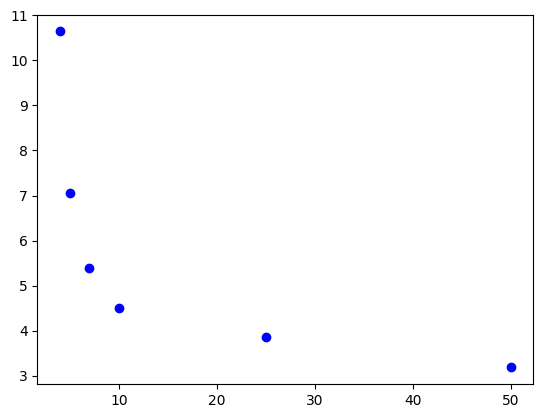

In [29]:
#remoção de outliers
num_grafos = n_grafos
media_taxa_acertos_total = tabela
for i in outliers['num_grafos']:
  if i in num_grafos:
    num_grafos.remove(i)
  if i in media_taxa_acertos_total['num_grafos']:
    media_taxa_acertos_total = media_taxa_acertos_total.drop(i) # Remoção dos outliers
    media_total = media_taxa_acertos_total['taxa_acertos'].mean()
print(f"\nMédia da taxa de acerto total: {media_total:.2f}\n\n\n")
# Calcular média relativa a cada num_grafos
media_relativa_num_grafos = media_taxa_acertos_total.groupby('num_grafos')['taxa_acertos'].mean()
valores_media = media_relativa_num_grafos.values
valores = []
for i in valores_media:
  valores.append(i)
#Criação da tabela com médias
dados_tabela_ng_medias = {'num_grafos': num_grafos, 'medias_acertos': valores}
tabela_ng_medias = pd.DataFrame(dados_tabela_ng_medias)
plt.scatter(dados_tabela_ng_medias['num_grafos'],dados_tabela_ng_medias['medias_acertos'], color = 'blue')
print(f'\n{tabela_ng_medias.to_string(index=False)}')

### **Estatística** (Em relação do Erro da Heurística Gulosa)

##### Regressão linear **num_grafos x taxa_acertos**

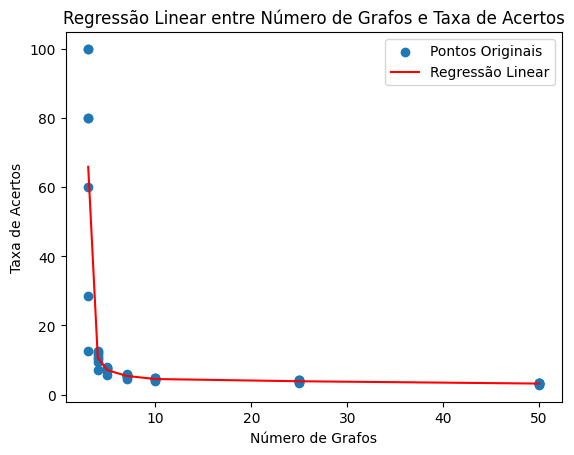

In [30]:
# Extrair os dados relevantes
x = tabela['num_grafos']
y = tabela['taxa_acertos']

# Calcular a regressão linear usando o método dos mínimos quadrados
# Utilizamos grau 6 pois o vetor tem tamanho 7 e não há distorção do comportamento da função
coeficientes = np.polyfit(x, y, 6)

# Criar a linha de melhor ajuste
linha_regressao = np.polyval(coeficientes, x)

# Criar um gráfico de dispersão
plt.scatter(x, y, label='Pontos Originais')
plt.plot(x, linha_regressao, color='red', label='Regressão Linear')

# Adicionar rótulos aos eixos
plt.xlabel('Número de Grafos')
plt.ylabel('Taxa de Acertos')

# Adicionar um título ao gráfico
plt.title('Regressão Linear entre Número de Grafos e Taxa de Acertos')

# Adicionar uma legenda
plt.legend()

# Exibir o gráfico
plt.show()

##### Correlação **acertos x num_vertices**

In [32]:
dados_correlacao = {'num_grafos': num_grafos_vetor, 'acertos': total_acertos_tabela, 'taxa_acertos': porcentagens_de_acertos, 'num_vertices': num_vertices_vetor}

# Converte o dicionário em uma tabela do Pandas
tabela_vertices_acertos = pd.DataFrame(dados_correlacao)

# Define a primeira coluna como cabeçalho
tabela_vertices_acertos = tabela.set_index('num_grafos')
lista_correlacoes = []
for n in num_grafos:
  dados_filtrados = tabela_vertices_acertos[tabela_vertices_acertos.index == n]
  correlacao_filtrada = dados_filtrados['num_vertices'].corr(dados_filtrados['acertos'])
  lista_correlacoes.append(correlacao_filtrada)

a = 0
for n in n_grafos:
  if lista_correlacoes[a] == max(lista_correlacoes):
    print(f'\nMaior correlação foi para {n} vértices com uma correlação de: {max(lista_correlacoes)}')
  if lista_correlacoes[a] == min(lista_correlacoes):
    print(f'\nMenor correlação foi para {n} vértices com uma correlação de: {min(lista_correlacoes)}')
  a+=1

correlacao_total = tabela_vertices_acertos['num_vertices'].corr(tabela_vertices_acertos['acertos'])
print(f'\ncorrelação total {correlacao_total}')

#Correlação fraca em alguns numeros de vértices e Correlação forte em outros, portanto inconclusivo.


Maior correlação foi para 4 vértices com uma correlação de: 0.8983378662509169

Menor correlação foi para 25 vértices com uma correlação de: -0.7321098609394961

correlação total 0.1194022965959372


### Discussões dos resultados


Foi possivel verificar alguns fatos interessantes, primeiro, a quantidade de arestas pode não impactar na quantidade de acertos e o que mais parece influenciar é a quantidade de grafos utilizados, isso pode decorrer do peso ser aleatório e quanto mais grafos mais aleatórios seriam os pesos, porem não podemos afirmar nada. Apenas uma inferencia de que a quantidade de grafos influencia de alguma maneira em uma menor taxa de acerto.

Fora isso também foi feito um estudo para verificar a correlação das variaveis que provou o ponto já dito.

Na primeira parte conseguimos verificar a diferença de tempo entre a heuristica gulosa e o algoritmo de dijkstra e é possivel ver que a heurística leva um tempo menor, porém é imprecisa. (como demonstrada na segunda parte do experimento)

---
TODOs:

* João:
    - ajustar a apresentação dos resultados
    - ver quais bibliotecas estão sendo realmente usadas

* Rodrigo:
    - tentar terminar a `Heurística Gulosa` (ver FIXME e TODO)

* Rodrigo + João:
    - revisar de forma crítica o Colab e o tex
    - postar o pdf e o Colab no Github
    - colocar o link para o pdf no começo do Colab
    - colocar o nome do repositório nas referências do tex


In [ ]:
####################
###  RECICLÁVEL  ###
####################


def vizinhos_do_grafo(grafo):
  """
  Essa função tem como ideia pegar todos os vizinhos de todos os nós para verificar se
  tem algum nó que não está conectado a nenhum outro vértice.

  Parâmetros:
    - grafo (dict): Dicionário de adjacências que representa o grafo
      ponderado. As chaves são os vértices do grafo e os valores são
      dicionários, cujas chaves são os vizinhos e os valores são os pesos das
      arestas que ligam os vértices.
  Saída:
    - lista com todas as adjascencias do grafo

  Complexidade:
      O(|V| + |E|), onde |V| é o número de vértices e |E| é o número de arestas.
    """

  lista_adjascencia = []
  for no in grafo.values():
      lista_adjascencia.extend(no.keys())

  return lista_adjascencia
